In [32]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

In [33]:
df = pd.read_csv('../data/Churn_Modelling.csv')
df.drop(columns=['RowNumber','CustomerId','Surname'],inplace=True)
df = pd.get_dummies(df, columns = ['Geography', 'Gender'], drop_first=True)
df

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,1,0,96270.64,0,False,False,True
9996,516,35,10,57369.61,1,1,1,101699.77,0,False,False,True
9997,709,36,7,0.00,1,0,1,42085.58,1,False,False,False
9998,772,42,3,75075.31,2,1,0,92888.52,1,True,False,True


In [34]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [37]:
# 데이터 전처리
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [38]:
# SVC 모델 정의
svc = SVC(probability=True)

# 탐색할 하이퍼파라미터 정의
params = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

# GridSearchCV 객체 생성
grid_search = GridSearchCV(svc, param_grid=params, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

# 학습
grid_search.fit(X_train, y_train)

# 최적 하이퍼파라미터 출력
print("Best parameters found: ", grid_search.best_params_)


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters found:  {'C': 1000, 'gamma': 0.01}


In [ ]:
# 모델 저장
filename = '../models/SVC.sav'
pickle.dump(grid_search, open(filename, 'wb'))

scaler_filename = '../models/SVC.scaler'

# 3. 스케일러 저장
with open(scaler_filename, "wb") as f:
    pickle.dump(sc, f)

In [40]:
# 모델 불러오기
loaded_svc = pickle.load(open(filename, 'rb'))

In [41]:
# 검증 데이터로 예측
y_pred = loaded_svc.best_estimator_.predict(X_test)

# 정확도
acc = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", acc)

# 정밀도, 재현율, F1 등 전체 리포트
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

✅ Accuracy: 0.8545

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.74      0.44      0.55       407

    accuracy                           0.85      2000
   macro avg       0.80      0.70      0.73      2000
weighted avg       0.84      0.85      0.84      2000



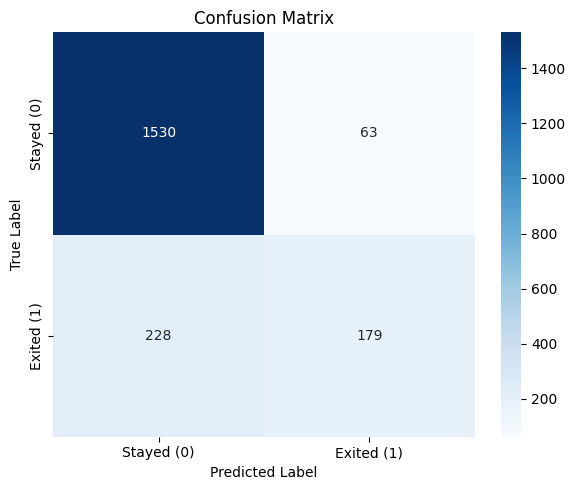

In [42]:
# 혼동 행렬 계산
cm = confusion_matrix(y_test, y_pred)

# 라벨 지정 (0: 잔류, 1: 이탈)
labels = ['Stayed (0)', 'Exited (1)']

# 시각화
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()


🔥 AUC Score: 0.8250


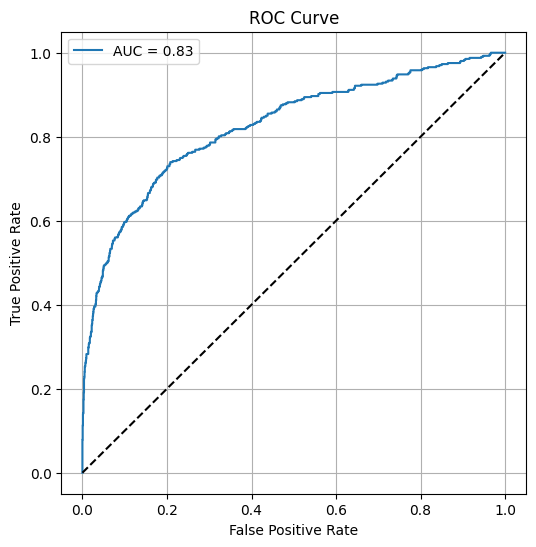

In [43]:
# AUC 계산

y_probs = loaded_svc.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, y_probs)
print(f"\n🔥 AUC Score: {auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # 대각선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()